___
# I - SETUP
___

___
## 1. General imports and Env path

In [1]:
CODEBASE_ROOTDIR = "/home/plumail/stage/minisource"

In [2]:
import os
os.chdir(CODEBASE_ROOTDIR)
import numpy as np
from typing import Tuple
from modules.pretraining.generate import DataGenerator
import modules.pretraining.generate.config as cfg
from modules.utils import summary, center_to_corners

___
## 2. Utilities

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def slice_in_3D(ax, slice_index=0, dim=0, zpos=0, shape=(100, 100, 100)):
    # From https://stackoverflow.com/questions/44881885/python-draw-3d-cube
    Z = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                  [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    Z = Z * shape
    r = [-1, 1]
    X, Y = np.meshgrid(r, r)
    # Plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
    # List sides' polygons of figure
    verts = [[Z[0], Z[1], Z[2], Z[3]],
             [Z[4], Z[5], Z[6], Z[7]],
             [Z[0], Z[1], Z[5], Z[4]],
             [Z[2], Z[3], Z[7], Z[6]],
             [Z[1], Z[2], Z[6], Z[5]],
             [Z[4], Z[7], Z[3], Z[0]],
             [Z[2], Z[3], Z[7], Z[6]]]
    # Plot sides
    sides = Poly3DCollection(verts,
                             facecolors=(1, 1, 1, 0.25), linewidths=1, edgecolors="black")
    ax.add_collection3d(sides)
    # Plot slice
    verts = [
        [[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]],
        [[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]],
        [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]]
    ]
    verts = np.array([verts[dim]])
    verts = verts * shape
    add = [0, 0, 0]
    add[dim] = slice_index
    verts   += add
    colors = ['red', 'green', 'blue']
    _slice = Poly3DCollection(verts, sort_zpos=zpos, facecolors=colors[dim],
                              alpha=0.9, linewidths=1, edgecolors="black")
    ax.add_collection3d(_slice)

    ax.set_xlabel("plane")
    ax.set_ylabel("row")
    ax.set_zlabel("col")

    # Autoscale plot axes
    scaling = np.array([getattr(ax, f'get_{dim}lim')() for dim in "xyz"])
    ax.auto_scale_xyz(* [[np.min(scaling), np.max(scaling)]] * 3)

def plot_3D_views(
    image: np.ndarray,
    x: int=None,
    y: int=None,
    z: int=None,
    figsize: Tuple[int]=(15, 15),
    grid: bool=True,
    channel_dim: bool=False,
) -> None:
    _  = plt.figure(figsize=figsize)
    xy = plt.subplot2grid((5, 5), (0, 0),   rowspan=4, colspan=4)
    zy = plt.subplot2grid((5, 5), (0, 4),   rowspan=4, colspan=1)
    xz = plt.subplot2grid((5, 5), (4, 0),   rowspan=1, colspan=4)
    cube = plt.subplot2grid((5, 5), (4, 4), rowspan=1, colspan=1, projection="3d")
    xy.set_xlabel('x', fontsize=25, color='red')
    zy.set_xlabel('z', fontsize=25, color='red', labelpad=100)
    zy.set_ylabel('y', fontsize=25, color='red')
    shape = image.shape[:-1] if channel_dim else image.shape
    y_view = (2, 1, 0, 3) if channel_dim else (2, 1, 0)
    x_view = (1, 0, 2, 3) if channel_dim else (1, 0, 2)
    d, h, w = shape
    x_coord = x if x is not None else w // 2
    y_coord = y if y is not None else h // 2
    z_coord = z if z is not None else d // 2
    xy.imshow(image[z_coord], cmap='gray')
    zy.imshow(image.transpose(y_view)[x_coord], cmap='gray')
    xz.imshow(image.transpose(x_view)[y_coord], cmap='gray')
    slice_in_3D(cube, slice_index=z_coord, dim=0, zpos=0, shape=shape)
    slice_in_3D(cube, slice_index=y_coord, dim=1, zpos=1, shape=shape)
    slice_in_3D(cube, slice_index=x_coord, dim=2, zpos=2, shape=shape)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    if grid:
        xy.grid()
        zy.grid()
        xz.grid()
    plt.show()

In [4]:
def plot_tilt_views(
    image: np.ndarray,
    centers: np.ndarray,
    views: np.ndarray,
    size: int=24,
    figsize: Tuple[int]=(15, 15)
) -> None:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image.sum(axis=0), cmap='gray')
    colors = ['red', 'green', 'blue']
    for i, (center, view) in enumerate(zip(centers, views)):
        x_min, y_min, z_min, x_max, y_max, z_max = center_to_corners(center, 3 * (size, ))
        width, height = x_max - x_min, y_max - y_min 
        ax.add_patch(Rectangle((x_min, y_min), width, height, color=colors[view], fill=False))
        annotate_kwargs = {'color': colors[view], 'fontsize': 12, 'ha': 'center', 'va': 'center'}
        ax.annotate(str(i), (x_min + width // 2, y_min - 5), **annotate_kwargs)
    plt.show() 

In [5]:
def fancy_print_config(config: cfg.DataGenerationConfig) -> None:
    for subconfig in ['io', 'voxelisation', 'augmentation', 'sensor']:
        subconfig_class = config.__getattribute__(subconfig)
        subconfig_dict = {k: v for k, v in subconfig_class.__dict__.items() if k[0] != '_'}
        summary(subconfig_dict, subconfig.upper())
    for i, outliers_pass in enumerate(config.outliers):
        subconfig_dict = {k: v for k, v in outliers_pass.__dict__.items() if k[0] != '_'}
        summary(subconfig_dict, f'outliers {i + 1}'.upper())

In [6]:
def init_base_config() -> cfg.DataGenerationConfig:
    config = cfg.DataGenerationConfig()
    outliers_pass1 = cfg.Outliers(
        radius_range_xy=(25, 80),
        radius_range_z=(20, 40),
        nb_points_range=(1000, 3000),
        nb_clusters_range=(100, 150),
        intensity_range=(0.5, 0.7),  
    )

    outliers_pass2 = cfg.Outliers(
        radius_range_xy=(150, 300),
        radius_range_z=(20, 40),
        nb_points_range=(500, 1000),
        nb_clusters_range=(100, 150),
        intensity_range=(0.5, 1.),  
    )
    config.outliers = (outliers_pass1, outliers_pass2)
    return config

___
## 3. Base config

In [7]:
config = init_base_config()

___
## 4. Custom config

In [8]:
""" Modify DataGenerationConfig attributes here. """
config.voxelisation.bandwidth = 5
config.sensor.gaussian_noise_target_snr_db = 10
config.sensor.poisson_noise = False

___
## 5. Summary

In [9]:
fancy_print_config(config)


+----------------------------------------------------------------------------------+
|                                        IO                                        |
+----------------------------------------------------------------------------------+
| point_cloud_path......: /data1/stage_Luc/inputs/sample_centriole_point_cloud.csv |
| output_dir............: /data1/stage_Luc/tilt/                                   |
| generated_dataset_size: 25                                                       |
+----------------------------------------------------------------------------------+


+--------------------------------------------+
|                VOXELISATION                |
+--------------------------------------------+
| num_particles.................: 150        |
| max_particle_dim..............: 25         |
| bandwidth.....................: 5          |
| epsilon.......................: 0.001      |
| cluster_range_xy..............: (100, 480) |
| cluster_range_z.........

___
# II - GENERATION
___

In [10]:
generator = DataGenerator(config)

In [11]:
""" This should takes around 2mn. """
centers, views = generator.create_image()

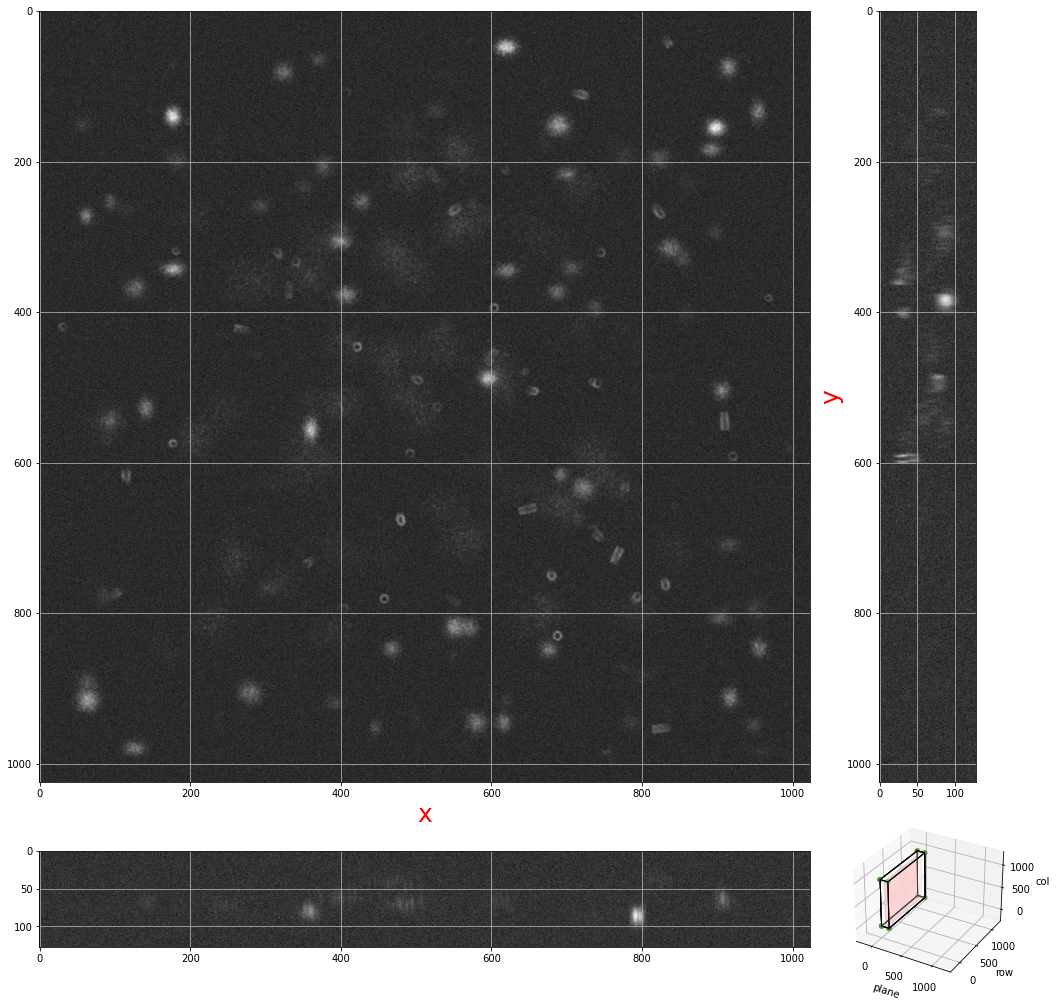

In [12]:
plot_3D_views(generator.output_image)

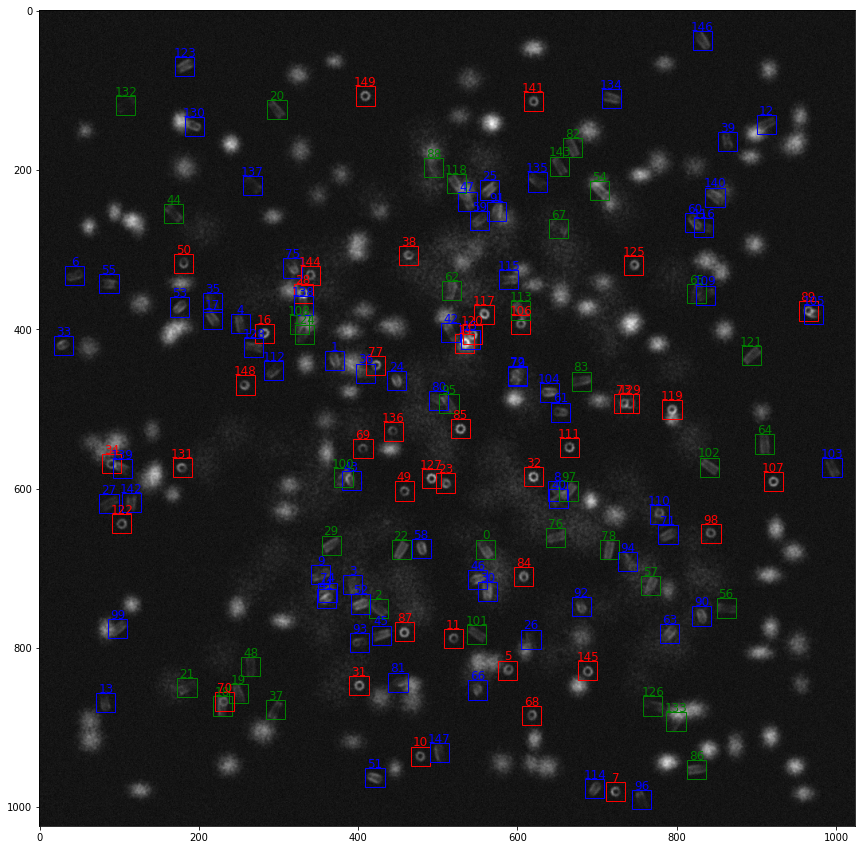

In [13]:
plot_tilt_views(generator.output_image, centers, views)

___
# III - IO

In [14]:
from skimage import img_as_ubyte
from modules.posttraining.evaluate import save_3d_image_to_tiff

In [15]:
OUTPUT_NAME = 'test'

In [17]:
output_path = os.path.join('datasamples', OUTPUT_NAME)
save_3d_image_to_tiff(img_as_ubyte(generator.output_image), output_path)